# Import Packages

In [170]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tkinter as tk
from tkinter import simpledialog, messagebox
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopword')
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
import re
import missingno as msno

[nltk_data] Error loading stopword: Package 'stopword' not found in
[nltk_data]     index


# Load the data

In [171]:
movies_data = pd.read_csv('movies.csv')
movies_data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [172]:
movies_data.shape

(4803, 24)

In [173]:
movies_data.duplicated().sum()

0

In [174]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

<Axes: >

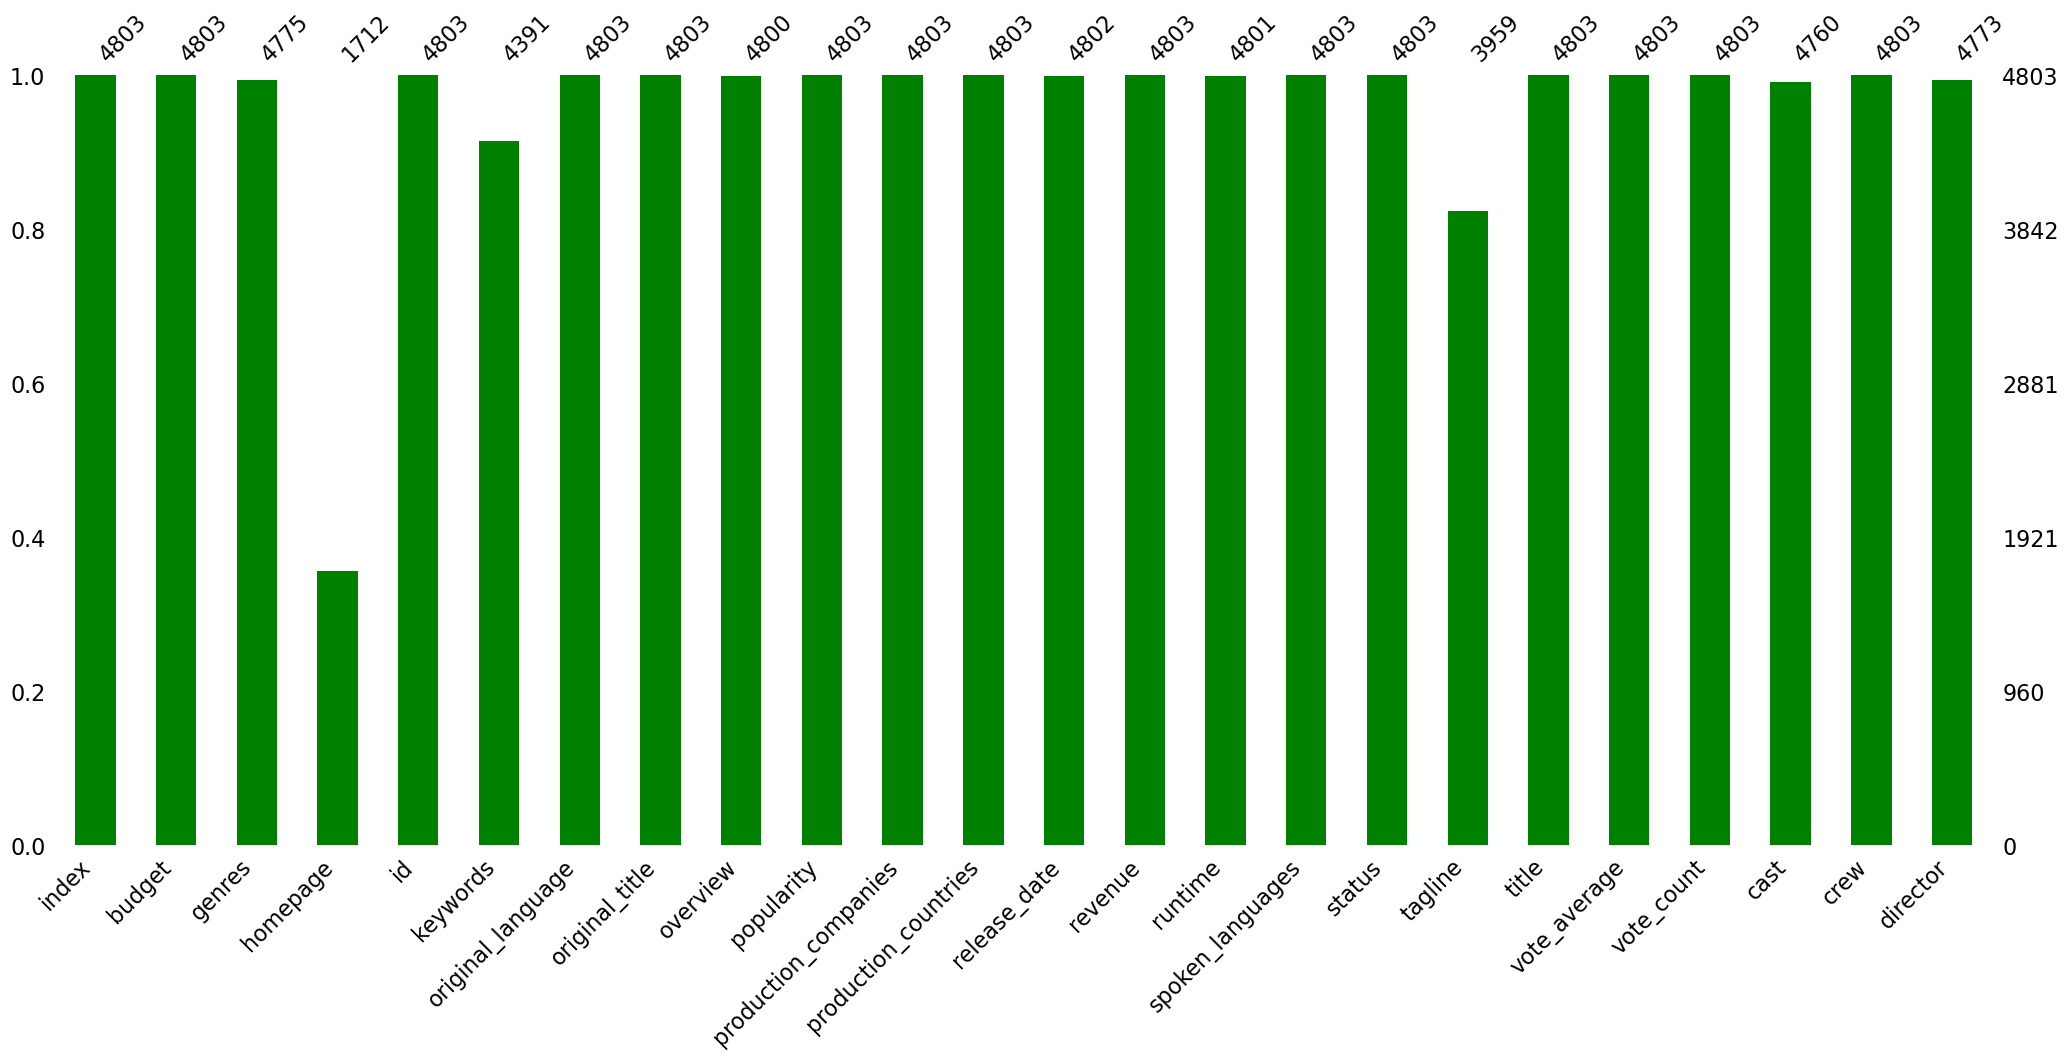

In [175]:
# Checking null values
msno.bar(movies_data,color='g')

# Data Preprocessing

Combine The Relevant Features

In [176]:
selected_features = ['genres','keywords','tagline','cast','director']
print(selected_features)

['genres', 'keywords', 'tagline', 'cast', 'director']


In [177]:
# replacing the null valuess with null string
for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

In [178]:
combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']

Text Cleaning

In [179]:
def remove_stop_words (text:str):
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

In [180]:
def remove_special_characters(text):
    special_char_pattern = re.compile(r'[^\w\s\u0600-\u06FF]')
    return special_char_pattern.sub('', text)

In [181]:
def remove_numbers(text):
    number_pattern = re.compile(r'\d+')
    return number_pattern.sub('', text)

In [182]:
def remove_multiple_spaces(text):
    space_pattern = re.compile(r'\s+')
    return space_pattern.sub(' ', text)

In [183]:
cleaned_text = []
def clean_all(text:str):
    ps = PorterStemmer()
    for sample in text:
        sample = sample.lower()
        sample = remove_stop_words(sample)
        sample = remove_special_characters(sample)
        sample = remove_numbers(sample)
        sample = remove_multiple_spaces(sample)
        sample = ps.stem(sample)
        cleaned_text.append(sample)

In [184]:
clean_all(combined_features)

In [185]:
len(combined_features[50]),len(cleaned_text[50])

(193, 180)

Text Vectorization

In [186]:
# converting the text data to vectors
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)

In [187]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Recommendation Function

In [194]:
def get_recommendations(movie_name):
    list_of_all_titles = df['title'].tolist()
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
    
    if not find_close_match:
        return ["No close match found for the given movie title."]
    
    close_match = find_close_match[0]
    index_of_the_movie = df[df.title == close_match]['index'].values[0]
    similarity_score = list(enumerate(cosine_sim[index_of_the_movie]))
    sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)

    recommended_movies = []
    for movie in sorted_similar_movies[1:31]:  # Exclude the first one as it is the input movie itself
        index = movie[0]
        title_from_index = df.iloc[index]['title']
        recommended_movies.append(title_from_index)
    
    return recommended_movies


# GUI

In [195]:
class MovieRecommenderApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Movie Recommender System")
        self.root.geometry("700x600")
        self.root.configure(bg='#2c3e50')
        
        # Header Frame
        self.header_frame = tk.Frame(self.root, bg='#2c3e50')
        self.header_frame.pack(pady=20)


        # Title
        self.title_label = tk.Label(self.header_frame, text="Movie Recommender System", font=("Helvetica", 24, "bold"), bg='#2c3e50', fg='white')
        self.title_label.grid(row=0, column=1, padx=10, sticky='w')

        # Subtitle
        self.subtitle_label = tk.Label(self.header_frame, text="Find your next favorite movie!", font=("Helvetica", 14), bg='#2c3e50', fg='white')
        self.subtitle_label.grid(row=1, column=1, padx=10, sticky='w')

        # Input Frame
        self.input_frame = tk.Frame(self.root, bg='#2c3e50')
        self.input_frame.pack(pady=20)

        self.label = tk.Label(self.input_frame, text="Enter movie title:", font=("Helvetica", 12), bg='#2c3e50', fg='white')
        self.label.grid(row=0, column=0, padx=10, pady=10, sticky='e')

        self.entry = ttk.Entry(self.input_frame, font=("Helvetica", 12), width=40)
        self.entry.grid(row=0, column=1, padx=10, pady=10, sticky='w')

        self.button_frame = tk.Frame(self.root, bg='#2c3e50')
        self.button_frame.pack(pady=10)

        self.recommend_button = ttk.Button(self.button_frame, text="Get Recommendations", command=self.recommend_movies, style='TButton')
        self.recommend_button.grid(row=0, column=0, padx=5)

        self.clear_button = ttk.Button(self.button_frame, text="Clear", command=self.clear_results, style='TButton')
        self.clear_button.grid(row=0, column=1, padx=5)

        # Result display
        self.result_label = tk.Label(self.root, text="Recommended Movies:", font=("Helvetica", 12), bg='#2c3e50', fg='white')
        self.result_label.pack(pady=5)

        self.result_text = scrolledtext.ScrolledText(self.root, height=10, width=60, font=("Helvetica", 12), wrap=tk.WORD)
        self.result_text.pack(pady=10)

        # Styles
        style = ttk.Style()
        style.configure('TButton', font=('Helvetica', 12), padding=10)

    def recommend_movies(self):
        movie_title = self.entry.get().strip()
        recommendations = get_recommendations(movie_title)
        self.result_text.delete(1.0, tk.END)
        if recommendations is not None:
            for movie in recommendations:
                self.result_text.insert(tk.END, movie.title() + "\n")
        else:
            messagebox.showerror("Error", "Movie not found in database")

    def clear_results(self):
        self.entry.delete(0, tk.END)
        self.result_text.delete(1.0, tk.END)

if __name__ == "__main__":
    root = tk.Tk()
    app = MovieRecommenderApp(root)
    root.mainloop()
